In [1]:
!pip install torchmetrics -q

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, roc_auc_score
from torchmetrics.classification import MulticlassAUROC

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.2 MB/s eta 0:00:00
Using device: cuda


In [2]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)

val_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

num_classes = 10

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [3]:
def get_resnet18():
    model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def get_resnet50():
    model = torchvision.models.resnet50(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

In [4]:
def train_model(model, train_loader, val_loader,
                lr=1e-4, weight_decay=1e-4, epochs=10):

    optimizer = optim.Adam(model.parameters(),
                           lr=lr,
                           weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float("inf")
    patience = 3
    trigger = 0

    for epoch in range(epochs):

        # ---- TRAIN ----
        model.train()
        running_loss, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ---- VALIDATION ----
        model.eval()
        running_loss, correct = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = correct / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: "
              f"Train Acc {train_acc:.4f}, "
              f"Val Acc {val_acc:.4f}")

        # ---- EARLY STOPPING ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses, train_accs, val_accs

In [5]:
model18 = get_resnet18()

loss18, valloss18, acc18, valacc18 = train_model(
    model18,
    train_loader,
    val_loader,
    lr=1e-4,
    weight_decay=1e-4,
    epochs=10
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Epoch 1: Train Acc 0.8838, Val Acc 0.9302
Epoch 2: Train Acc 0.9447, Val Acc 0.9425
Epoch 3: Train Acc 0.9616, Val Acc 0.9431
Epoch 4: Train Acc 0.9702, Val Acc 0.9409
Epoch 5: Train Acc 0.9771, Val Acc 0.9436
Early stopping triggered


In [6]:
model50 = get_resnet50()

loss50, valloss50, acc50, valacc50 = train_model(
    model50,
    train_loader,
    val_loader,
    lr=1e-4,
    weight_decay=1e-4,
    epochs=10
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


Epoch 1: Train Acc 0.8945, Val Acc 0.9294
Epoch 2: Train Acc 0.9444, Val Acc 0.9489
Epoch 3: Train Acc 0.9598, Val Acc 0.9418
Epoch 4: Train Acc 0.9679, Val Acc 0.9519
Epoch 5: Train Acc 0.9723, Val Acc 0.9421
Epoch 6: Train Acc 0.9736, Val Acc 0.9504
Epoch 7: Train Acc 0.9768, Val Acc 0.9387
Early stopping triggered


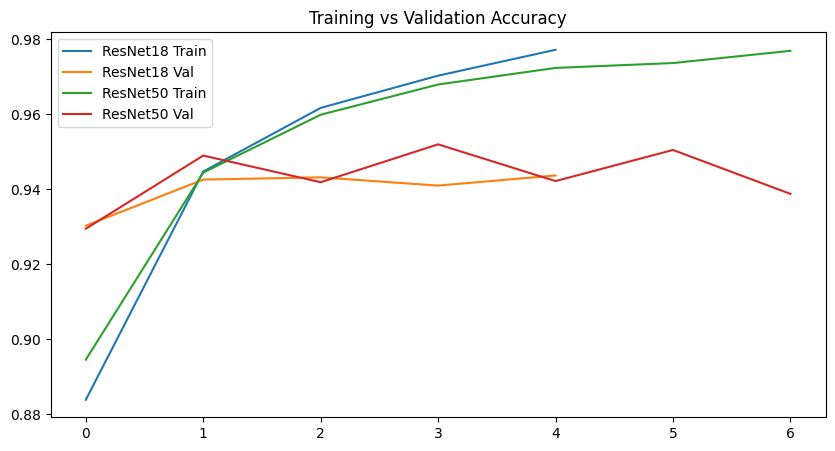

In [7]:
plt.figure(figsize=(10,5))
plt.plot(acc18, label="ResNet18 Train")
plt.plot(valacc18, label="ResNet18 Val")
plt.plot(acc50, label="ResNet50 Train")
plt.plot(valacc50, label="ResNet50 Val")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [8]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)

            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    print(classification_report(all_labels, all_preds))

    auroc = MulticlassAUROC(num_classes=num_classes)
    auroc_score = auroc(torch.tensor(all_probs),
                        torch.tensor(all_labels))
    print("ROC-AUC:", auroc_score.item())

print("ResNet18 Metrics:")
evaluate_model(model18, val_loader)

print("ResNet50 Metrics:")
evaluate_model(model50, val_loader)

ResNet18 Metrics:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1000
           1       0.97      0.97      0.97      1000
           2       0.92      0.94      0.93      1000
           3       0.88      0.88      0.88      1000
           4       0.96      0.93      0.94      1000
           5       0.91      0.90      0.90      1000
           6       0.98      0.95      0.97      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

ROC-AUC: 0.9978785514831543
ResNet50 Metrics:


/tmp/ipython-input-2438490254.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  auroc_score = auroc(torch.tensor(all_probs),


              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1000
           1       0.96      0.98      0.97      1000
           2       0.81      0.98      0.89      1000
           3       0.91      0.87      0.89      1000
           4       0.96      0.95      0.95      1000
           5       0.93      0.92      0.92      1000
           6       0.97      0.96      0.97      1000
           7       0.99      0.95      0.97      1000
           8       0.96      0.97      0.96      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

ROC-AUC: 0.997838020324707


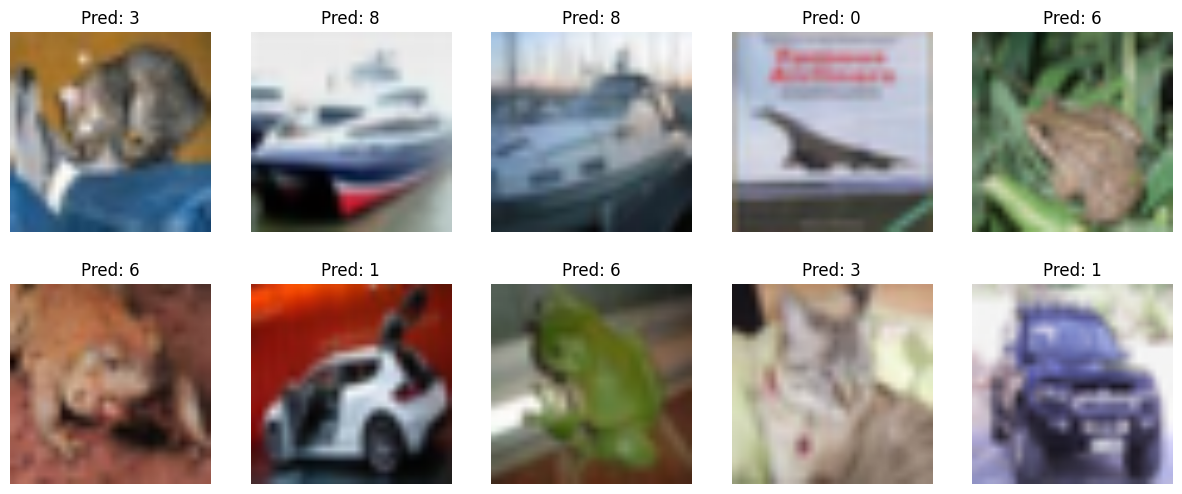

In [9]:
def show_predictions(model, loader):
    model.eval()
    images, labels = next(iter(loader))
    images = images.to(device)

    outputs = model(images)
    preds = outputs.argmax(1)

    fig, axes = plt.subplots(2,5, figsize=(15,6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].cpu().permute(1,2,0))
        ax.set_title(f"Pred: {preds[i].item()}")
        ax.axis("off")

    plt.show()

show_predictions(model18, val_loader)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("ResNet18 Parameters:", count_parameters(model18))
print("ResNet50 Parameters:", count_parameters(model50))

ResNet18 Parameters: 11181642
ResNet50 Parameters: 23528522


Part 4

In [11]:
import torch
import torch.nn.utils.prune as prune
import time
import os
import copy
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def get_model_size(model, name="temp.pth"):
    torch.save(model.state_dict(), name)
    size = os.path.getsize(name) / 1e6
    os.remove(name)
    return round(size, 2)

In [13]:
def benchmark_inference(model, loader, num_batches=50):
    model.eval()
    model.to(device)

    start = time.time()

    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches:
                break
            images = images.to(device)
            _ = model(images)

    end = time.time()

    total_images = num_batches * loader.batch_size
    total_time = end - start

    ms_per_image = (total_time / total_images) * 1000
    return round(ms_per_image, 3)

In [14]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return round(correct / total, 4)

In [15]:
baseline_model = model18  # from Part 2

baseline_size = get_model_size(baseline_model)
baseline_time = benchmark_inference(baseline_model, val_loader)
baseline_acc = evaluate_accuracy(baseline_model, val_loader)

print("Baseline Size (MB):", baseline_size)
print("Baseline Inference (ms/image):", baseline_time)
print("Baseline Accuracy:", baseline_acc)

Baseline Size (MB): 44.8
Baseline Inference (ms/image): 1.357
Baseline Accuracy: 0.9436


In [16]:
pruned_model = copy.deepcopy(baseline_model)

for module in pruned_model.modules():
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name="weight", amount=0.3)

pruned_size = get_model_size(pruned_model)
pruned_time = benchmark_inference(pruned_model, val_loader)
pruned_acc = evaluate_accuracy(pruned_model, val_loader)

print("Pruned Size (MB):", pruned_size)
print("Pruned Inference (ms/image):", pruned_time)
print("Pruned Accuracy:", pruned_acc)

Pruned Size (MB): 89.47
Pruned Inference (ms/image): 1.569
Pruned Accuracy: 0.9364


In [19]:
# Create CPU copy of baseline model
baseline_cpu = copy.deepcopy(baseline_model).cpu()
baseline_cpu.eval()

# Apply dynamic quantization (CPU only)
quantized_model = torch.quantization.quantize_dynamic(
    baseline_cpu,
    {torch.nn.Linear},
    dtype=torch.qint8
)

# CPU-only accuracy function
def evaluate_accuracy_cpu(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.cpu()
            labels = labels.cpu()
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return round(correct / total, 4)


# CPU-only benchmark function
def benchmark_inference_cpu(model, loader, num_batches=50):
    model.eval()
    start = time.time()

    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches:
                break
            images = images.cpu()
            _ = model(images)

    end = time.time()

    total_images = num_batches * loader.batch_size
    total_time = end - start

    return round((total_time / total_images) * 1000, 3)


# Measure metrics
quantized_size = get_model_size(quantized_model)
quantized_time = benchmark_inference_cpu(quantized_model, val_loader)
quantized_acc = evaluate_accuracy_cpu(quantized_model, val_loader)

print("Quantized Size (MB):", quantized_size)
print("Quantized Inference (ms/image):", quantized_time)
print("Quantized Accuracy:", quantized_acc)

/tmp/ipython-input-3371830285.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


Quantized Size (MB): 44.78
Quantized Inference (ms/image): 167.334
Quantized Accuracy: 0.9435


In [20]:
results = pd.DataFrame({
    "Model": ["Baseline", "Pruned (30%)", "Quantized (INT8)"],
    "Size (MB)": [baseline_size, pruned_size, quantized_size],
    "Inference (ms/image)": [baseline_time, pruned_time, quantized_time],
    "Accuracy": [baseline_acc, pruned_acc, quantized_acc]
})

results

,Model,Size (MB),Inference (ms/image),Accuracy
0,Baseline,44.80,1.357,0.9436
1,Pruned (30%),89.47,1.569,0.9364
2,Quantized (INT8),44.78,167.334,0.9435
